In [1]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

from tl._exp_dist import exp_dist
from tl._spatial_de import spatial_de
from pl._pl_spatial_de import pl_spatial_de

from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.genmod.generalized_estimating_equations import GLM


In [2]:
adata = sc.read_h5ad("C://backup/Bachelorarbeit/LiverAgeing_pp_lowres.h5ad")

annotate central and portal vein based on umap-spline:

In [3]:
adata.obs["vein_type"] = "lobular_axis"
pv = list(adata[adata.obs["umap_spline"] <= 0.2].obs.index)
cv = list(adata[adata.obs["umap_spline"] >= 0.9].obs.index)
adata.obs.loc[adata.obs.index.isin(pv), "vein_type"]  = "portal_vein"
adata.obs.loc[adata.obs.index.isin(cv), "vein_type"]  = "central_vein"

central and portal vein markers

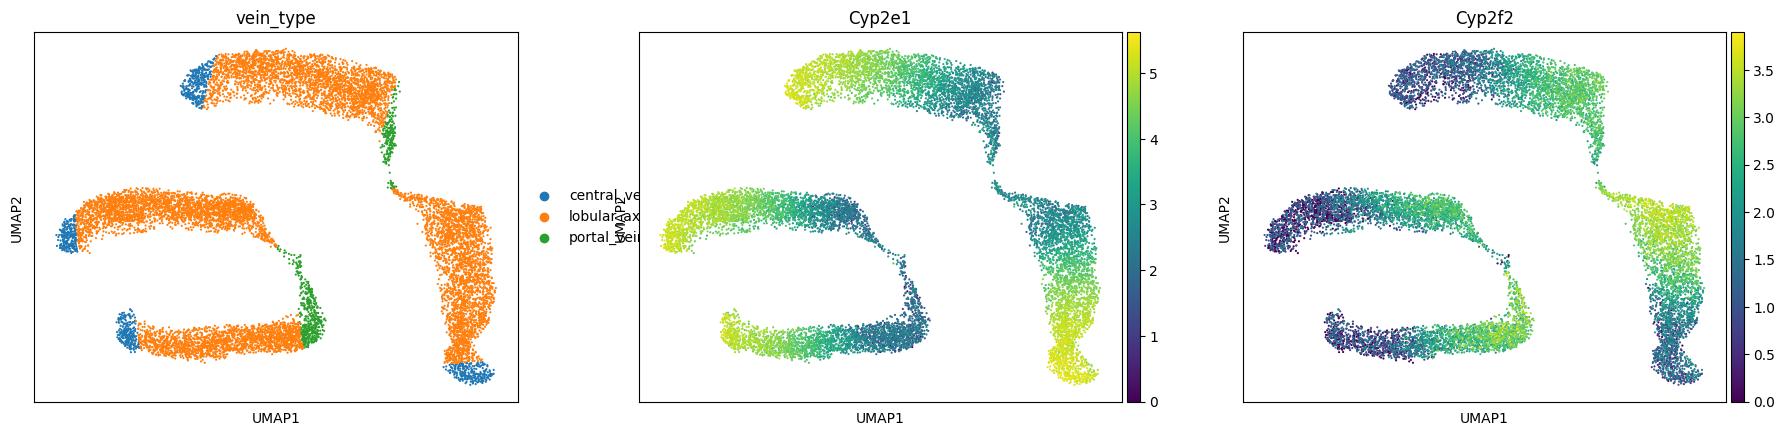

In [4]:
sc.pl.umap(adata, color=["vein_type","Cyp2e1","Cyp2f2"])

restrict to highly variable genes (2000 genes)

In [5]:
adata = adata[:, adata.var.highly_variable]

build design matrix with portal vein as anchor point

In [6]:
exp_dist(adata, groups="portal_vein" , cluster_key="vein_type",batch_key="mouse_id", covariates='age')

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [7]:
adata.obsm["design_matrix"]

,vein_type,portal_vein,mouse_id,portal_vein_raw,age
12x15-37_30_A1,lobular_axis,0.140440,TS16,895.797739,old
12x19-37_30_A1,lobular_axis,0.170848,TS16,1089.750751,old
12x18-37_30_A1,lobular_axis,0.191013,TS16,1218.378378,old
12x17-37_30_A1,central_vein,0.208310,TS16,1328.706085,old
12x16-37_30_A1,lobular_axis,0.173490,TS16,1106.606926,old
...,...,...,...,...,...
18x27-37_43_C3,lobular_axis,0.212395,TS28,1354.763162,young
18x22-37_43_C3,lobular_axis,0.139926,TS28,892.519441,young
18x21-37_43_C3,lobular_axis,0.176921,TS28,1128.491080,young
18x24-37_43_C3,lobular_axis,0.140140,TS28,893.884089,young


GAM: gexp ~ vein_type + B(dist_to_pv)

In [8]:
spatial_de(adata, "design_matrix", "portal_vein", covariates="age")

In [9]:
adata.uns["design_matrix_DEGs"]

,gene,p-val,fc,p-val_adj
839,Gm49333,0.993941,-0.000434,0.993941
793,Gm37965,0.988345,0.000505,0.988839
1591,Rpl29-ps2,0.986880,-0.000742,0.987868
859,Gm8013,0.984432,-0.000695,0.985911
356,Chrna9,0.982195,-0.000502,0.984164
...,...,...,...,...
478,Cyp8b1,0.000000,0.579402,0.000000
477,Cyp7b1,0.000000,0.979320,0.000000
476,Cyp7a1,0.000000,0.807948,0.000000
472,Cyp4a12b,0.000000,0.438634,0.000000


In [16]:
pl_spatial_de(adata=adata)

c:\Users\laure\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

divide by zero encountered in log10

c:\Users\laure\Desktop\github\squidpy\squidpy\pl\_pl_spatial_de.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



significantly spatially DEGs:

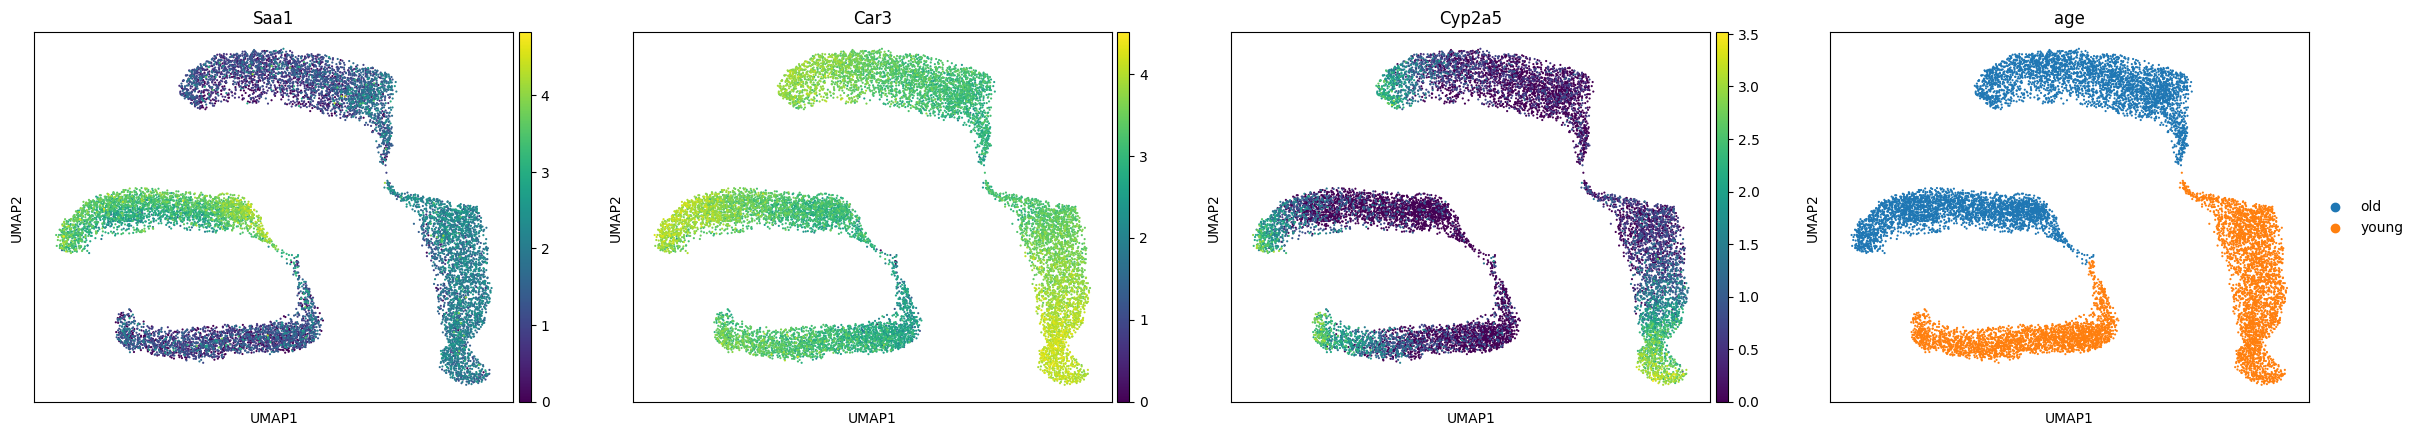

In [11]:
sc.pl.umap(adata, color=["Saa1","Car3","Cyp2a5","age"])

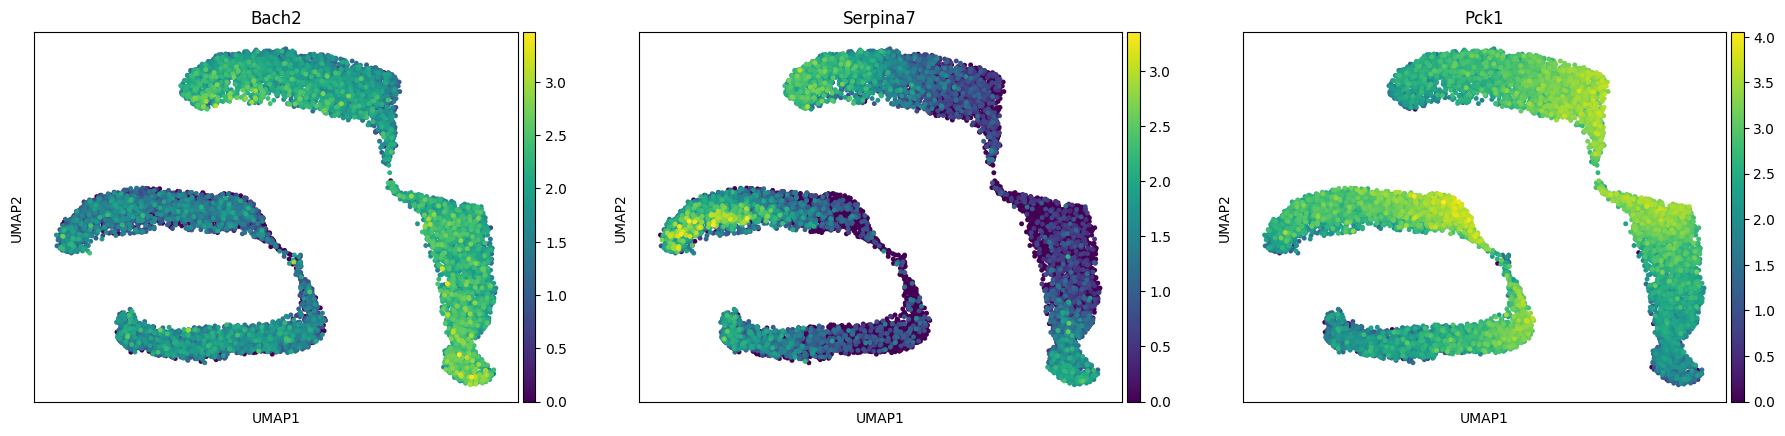

In [12]:
sc.pl.umap(adata, color=["Bach2","Serpina7","Pck1"], s=50)

In [13]:
adata.uns["design_matrix_DEGs"][adata.uns["design_matrix_DEGs"]["gene"] == "Bach2"]

,gene,p-val,fc,p-val_adj,log_pval,l2fc
193,Bach2,1.395771e-310,0.372041,3.446348e-309,308.462641,-1.426465


<AxesSubplot:xlabel='portal_vein', ylabel='Bach2'>

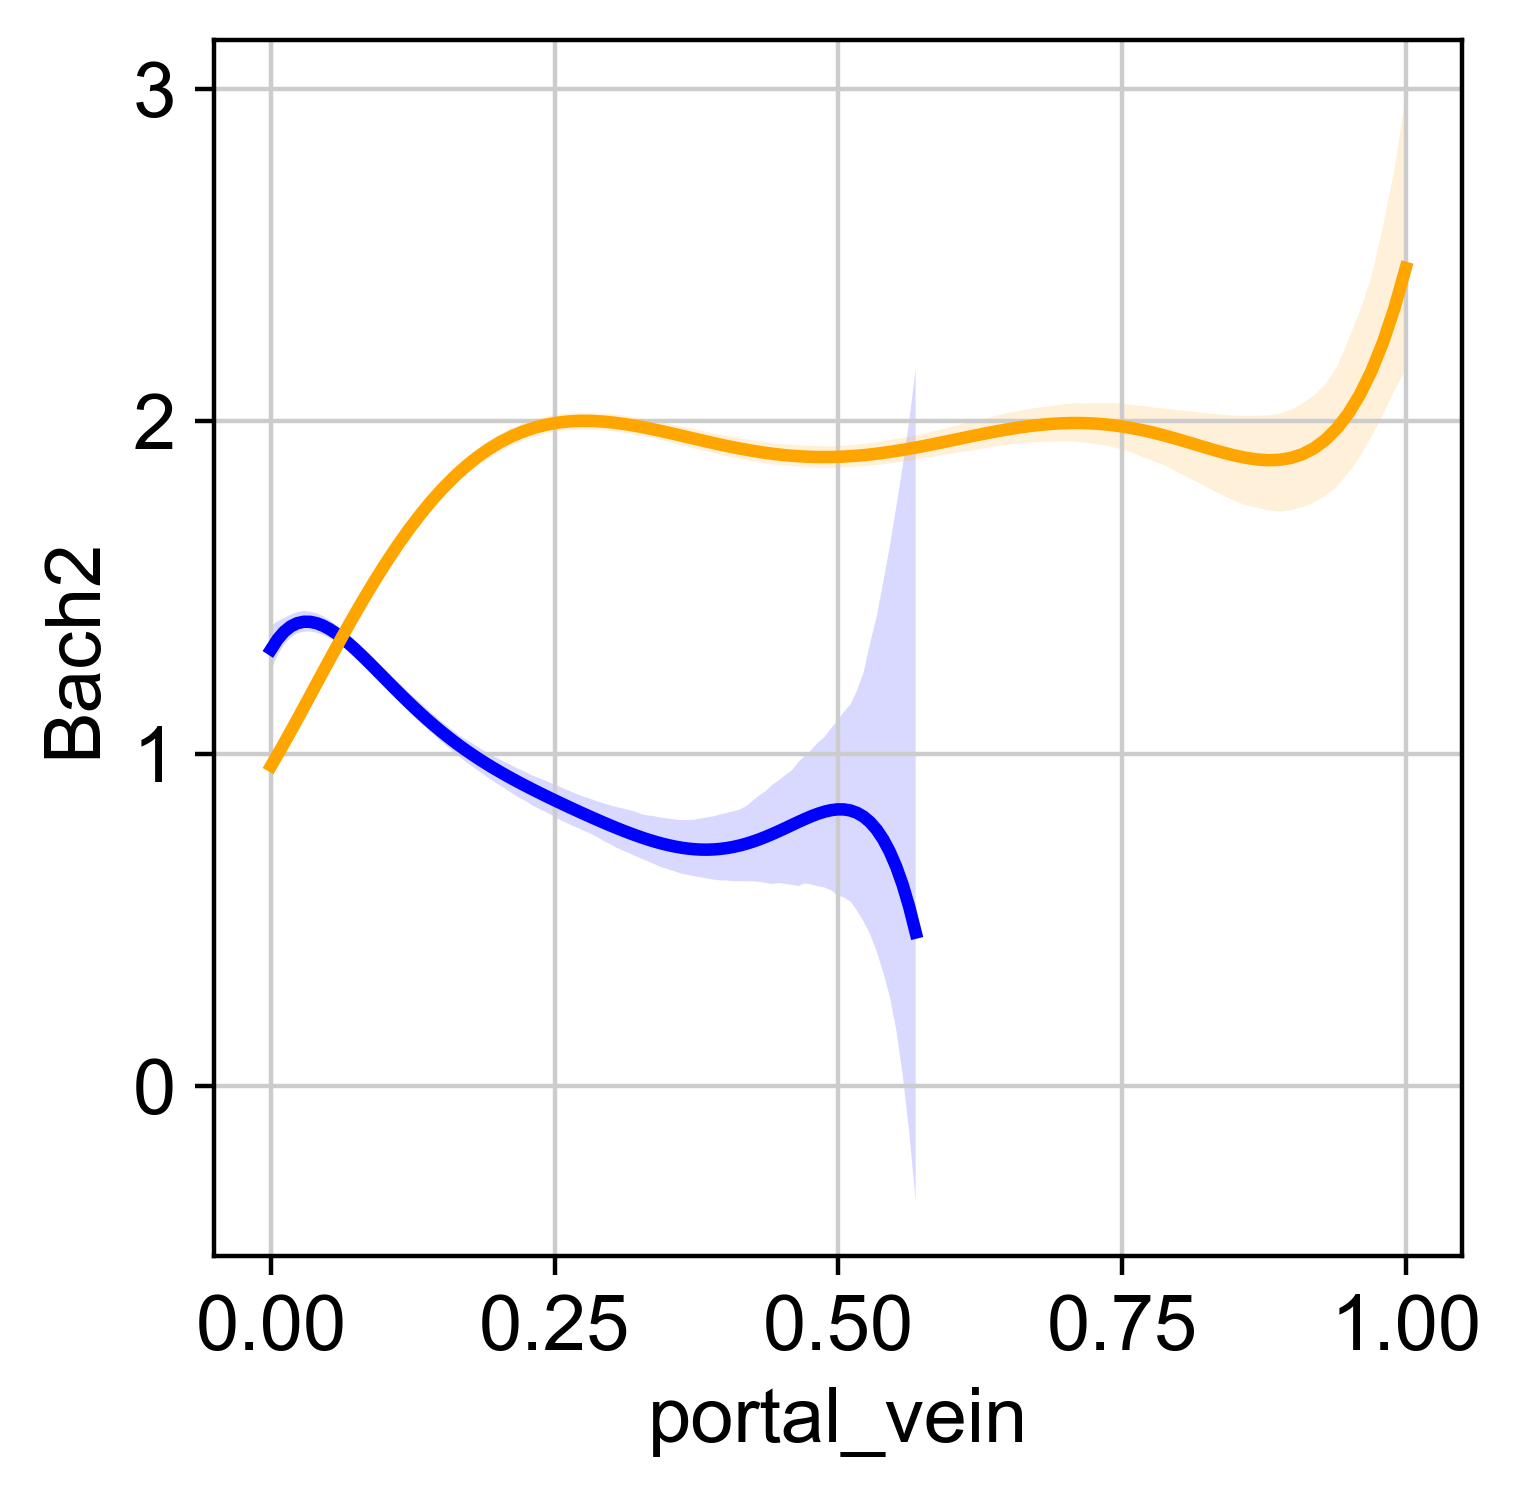

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.settings.set_figure_params(dpi=200, facecolor='white')
gene = 'Bach2'
adata.obsm['design_matrix'][gene] = np.array(adata[:, gene].X)
df = adata.obsm['design_matrix']
fig, ax = plt.subplots(1,1)

sns.regplot(data = df[df.age == "old"], x='portal_vein', y=gene, color='blue', order=6, scatter=False, ax=ax)
sns.regplot(data = df[df.age == "young"], x='portal_vein', y=gene, color='orange', order=6, scatter=False, ax=ax)

not significantly DEGs:

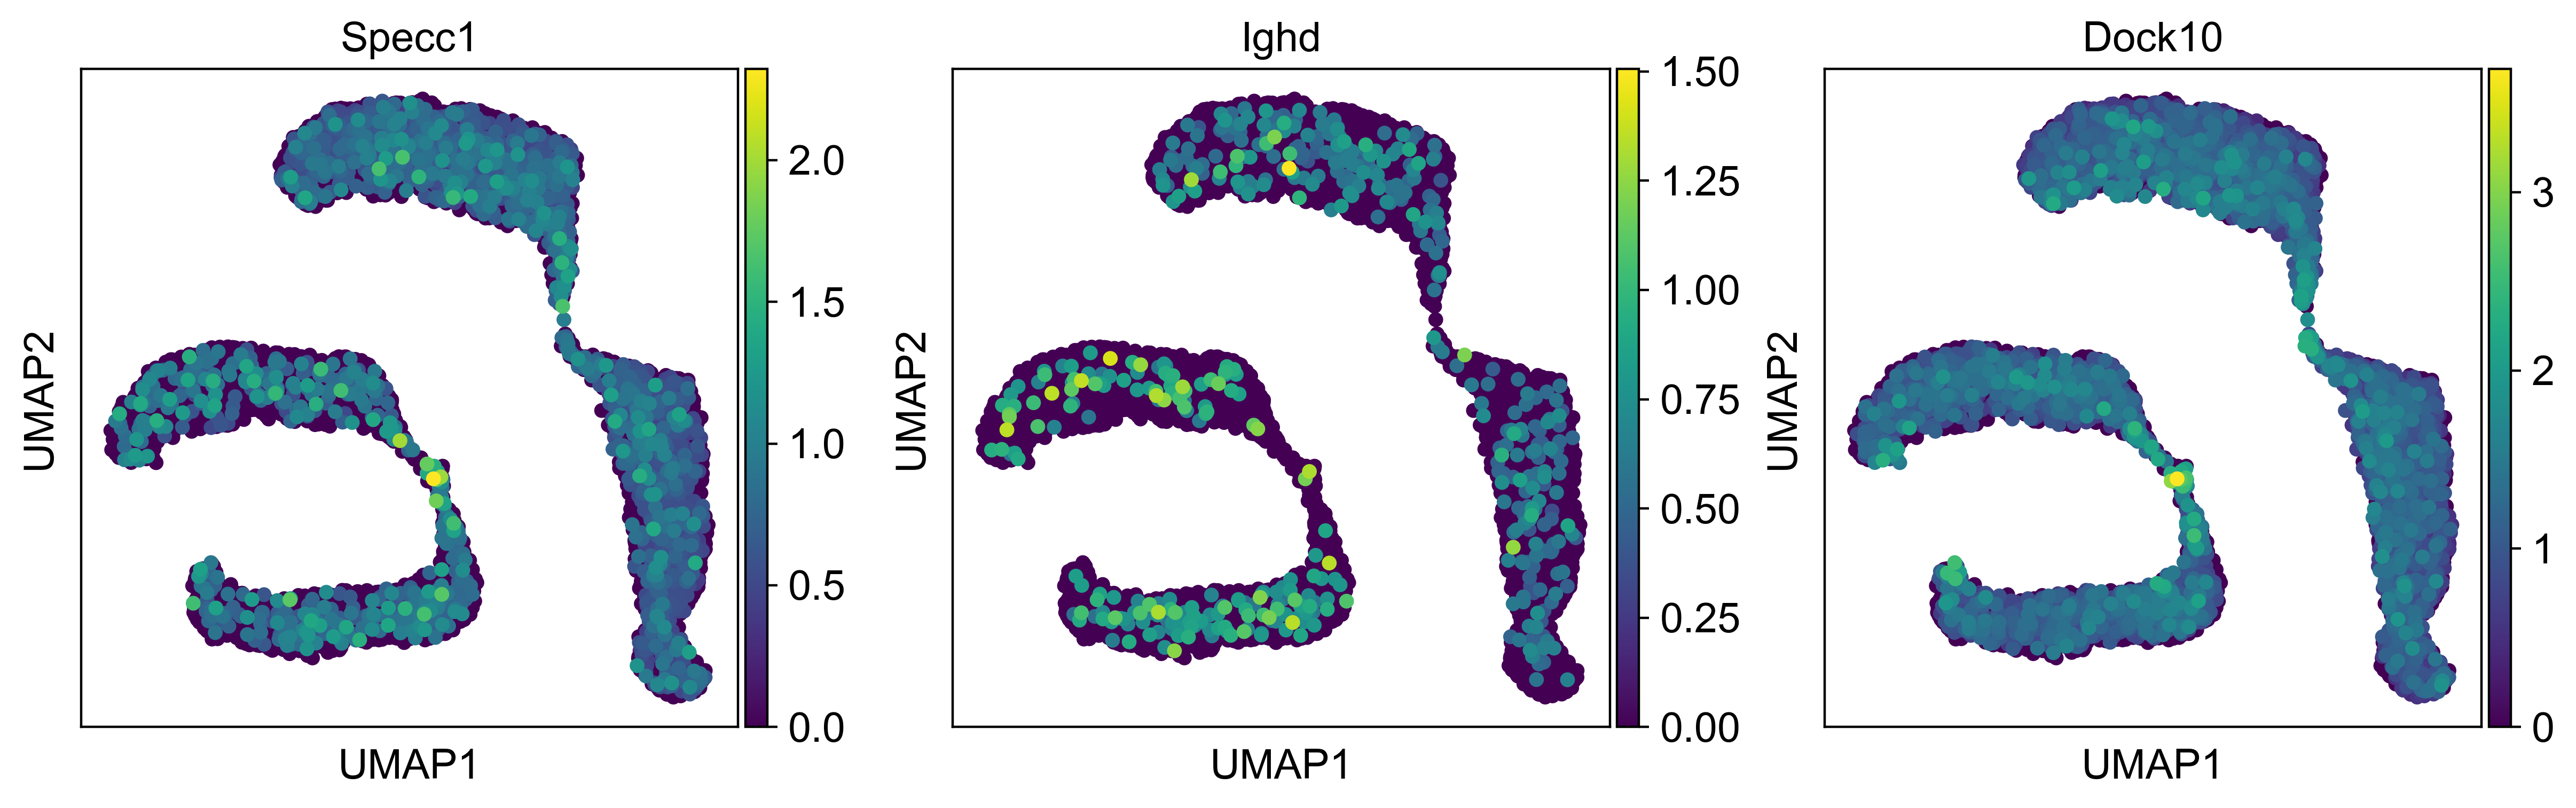

In [15]:
sc.pl.umap(adata, color=["Specc1","Ighd","Dock10"], s=100)